<a href="https://colab.research.google.com/github/yanpuri/CIFAR10-Network-Training/blob/main/CIFAR10_97_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

2.11.0


## **Importing the CIFAR10 set**

In [ ]:
# Load in the data
cifar10 = tf.keras.datasets.cifar10

# Distribute it to train and test set
(train_imgs, train_labels), (test_imgs, test_labels) = cifar10.load_data()


print(train_imgs.shape, train_labels.shape, test_imgs.shape, test_labels.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


## **Visualizing the dataset**

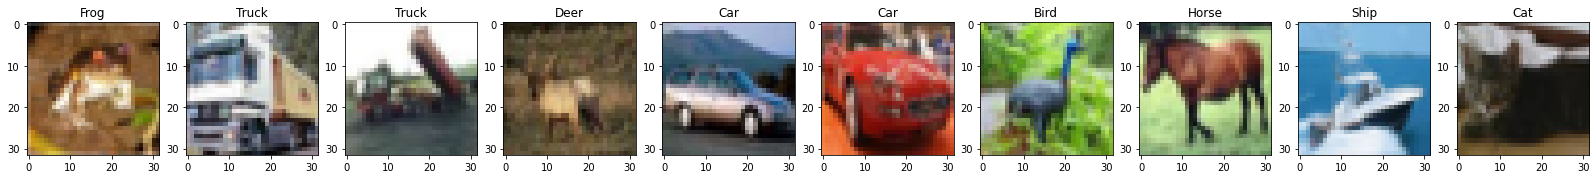

In [ ]:

class_names = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
fig, axes = plt.subplots(1,10,figsize=(28,28))

for i in range(10):
    axes[i].imshow(train_imgs[i], cmap='binary')
    axes[i].set_title(class_names[train_labels[i][0]])


## **Preparing the data**

In [ ]:
# Reduce pixel values
train_imgs, test_imgs = train_imgs / 255.0, test_imgs / 255.0
img_rows, img_cols , channels= 32,32,3
# Flatten the label values
train_labels, test_labels = train_labels.flatten(), test_labels.flatten()
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(train_imgs)

train_imgs = train_imgs.reshape(train_imgs.shape[0], img_rows, img_cols, channels)
test_imgs = test_imgs.reshape(test_imgs.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('train_imgs shape:', train_imgs.shape)
print(train_imgs.shape[0], 'train samples')
print(test_imgs.shape[0], 'test samples')

# Convert integers to float; Normalize and center the mean
train_imgs=train_imgs.astype("float32")
test_imgs=test_imgs.astype("float32")
mean=np.mean(train_imgs)
std=np.std(train_imgs)
test_imgs=(test_imgs-mean)/std
train_imgs=(train_imgs-mean)/std
# labels
num_classes=10

train_imgs shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


## **CNN Model Structure**

In [ ]:
def create_model():

 # Input layer
 i = Input(shape=train_imgs[0].shape)
 x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
 x = BatchNormalization()(x)
 x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
 x = BatchNormalization()(x)
 x = MaxPooling2D((2, 2))(x)

 x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
 x = BatchNormalization()(x)
 x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
 x = BatchNormalization()(x)
 x = MaxPooling2D((2, 2))(x)

 x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
 x = BatchNormalization()(x)
 x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
 x = BatchNormalization()(x)
 x = MaxPooling2D((2, 2))(x)

 x = Flatten()(x)
 x = Dropout(0.5)(x) #Neuron dropout to stop overfitting

# Hidden layer
 x = Dense(1024, activation='relu')(x)
 x = Dropout(0.5)(x)

# Output layer
 x = Dense(10, activation='softmax')(x)

 model = Model(i, x)
 return model


## **Model Summary**

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0     

## **TPU Setup**

In [ ]:
tf.keras.backend.clear_session()

resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)

tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.experimental.TPUStrategy(resolver)

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


## **TPU Compilation and Training**

In [ ]:

with strategy.scope():
  model = create_model()
  model.compile(
      optimizer='Adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'])

network = model.fit(
    train_imgs.astype(np.float32), train_labels.astype(np.float32),
    shuffle=True,
    epochs=50,
    steps_per_epoch=60,
    validation_data=(test_imgs.astype(np.float32), test_labels.astype(np.float32)),
    validation_freq=10
)

model.save_weights('./cifar10_weights.h5', overwrite=True)

Epoch 1/50
60/60 [==============================] - 7s 28ms/step - loss: 2.3224 - accuracy: 0.3464
Epoch 2/50
60/60 [==============================] - 2s 28ms/step - loss: 1.3969 - accuracy: 0.4945
Epoch 3/50
60/60 [==============================] - 2s 29ms/step - loss: 1.1939 - accuracy: 0.5721
Epoch 4/50
60/60 [==============================] - 2s 28ms/step - loss: 1.0382 - accuracy: 0.6305
Epoch 5/50
60/60 [==============================] - 2s 28ms/step - loss: 0.9300 - accuracy: 0.6681
Epoch 6/50
60/60 [==============================] - 2s 28ms/step - loss: 0.8354 - accuracy: 0.7039
Epoch 7/50
60/60 [==============================] - 2s 28ms/step - loss: 0.7624 - accuracy: 0.7304
Epoch 8/50
60/60 [==============================] - 2s 28ms/step - loss: 0.7040 - accuracy: 0.7506
Epoch 9/50
60/60 [==============================] - 2s 29ms/step - loss: 0.6460 - accuracy: 0.7709
Epoch 10/50
60/60 [==============================] - 8s 133ms/step - loss: 0.6014 - accuracy: 0.7854 - val_lo

## **Evaluation**

In [ ]:
train_acc = model.evaluate(test_imgs,test_labels,batch_size=128)

print(f"Accuracy:{train_acc}")

79/79 [==============================] - 3s 19ms/step - loss: 0.7156 - accuracy: 0.8285
Accuracy:[0.7156087160110474, 0.828499972820282]


## **Loss vs. Epochs**

Text(0.5, 0, 'epoch')

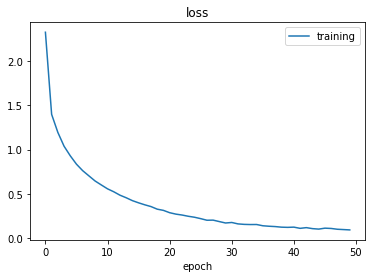

In [ ]:
#plotting the loss graph
plt.plot(network.history['loss'])
plt.legend(['training' , 'validation'])
plt.title('loss')
plt.xlabel('epoch')

## **Accuracy vs. Epochs**

Text(0.5, 0, 'epoch')

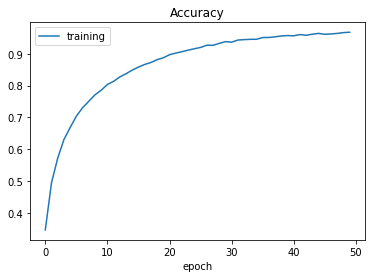

In [ ]:
#plotting the accuracy graph
plt.plot(network.history['accuracy'])
plt.legend(['training' , 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

## **Accuracy vs. Loss**

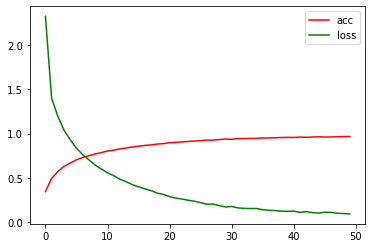

In [ ]:
# Plot accuracy per iteration
plt.plot(network.history['accuracy'], label='acc', color='red')
plt.plot(network.history['loss'], label='loss', color='green')
plt.legend()

## **Predictions**

1/1 [==============================] - 1s 551ms/step
Original label is Horse and predicted label is Horse


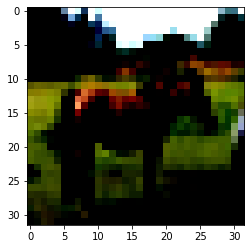

In [ ]:
# label mapping

labels = '''Plane Car Bird Cat Deer Dog Frog Horse Ship Truck'''.split()

# select the image from our test dataset
image_number = 9999

plt.imshow(test_imgs[image_number])
n = np.array(test_imgs[image_number])
p = n.reshape(1, 32, 32, 3)
# pass in the network for prediction and
predicted_label = labels[model.predict(p).argmax()]
original_label = labels[test_labels[image_number]]

print("Original label is {} and predicted label is {}".format(
	original_label, predicted_label))
